In [ ]:
import regex as re
import os
import numpy as np
import pandas as pd
import hashlib
from datetime import datetime


class Logcluster:
    def __init__(self, logTemplate='', logIDL=None):
        self.logTemplate = logTemplate
        if logIDL is None:
            logIDL = []
        self.logIDL = logIDL


class Node:
    def __init__(self, childD=None, depth=0, digitOrtoken=None):
        if childD is None:
            childD = dict()
        self.childD = childD
        self.depth = depth
        self.digitOrtoken = digitOrtoken


class LogParser:
    def __init__(self, log_format, indir='./', outdir='./result/', depth=4, st=0.4, 
                 maxChild=100, rex=[], keep_para=True):
        """
        Attributes
        ----------
            rex : regular expressions used in preprocessing (step1)
            path : the input path stores the input log file name
            depth : depth of all leaf nodes
            st : similarity threshold
            maxChild : max number of children of an internal node
            logName : the name of the input file containing raw log messages
            savePath : the output path stores the file containing structured logs
        """
        self.path = indir
        self.depth = depth - 2
        self.st = st
        self.maxChild = maxChild
        self.logName = None
        self.savePath = outdir
        self.df_log = None
        self.log_format = log_format
        self.rex = rex
        self.keep_para = keep_para

    def hasNumbers(self, s):
        return any(char.isdigit() for char in s)

    def treeSearch(self, rn, seq):
        retLogClust = None

        seqLen = len(seq)
        if seqLen not in rn.childD:
            return retLogClust

        parentn = rn.childD[seqLen]

        currentDepth = 1
        for token in seq:
            if currentDepth >= self.depth or currentDepth > seqLen:
                break

            if token in parentn.childD:
                parentn = parentn.childD[token]
            elif '<*>' in parentn.childD:
                parentn = parentn.childD['<*>']
            else:
                return retLogClust
            currentDepth += 1

        logClustL = parentn.childD

        retLogClust = self.fastMatch(logClustL, seq)

        return retLogClust

    def addSeqToPrefixTree(self, rn, logClust):
        seqLen = len(logClust.logTemplate)
        if seqLen not in rn.childD:
            firtLayerNode = Node(depth=1, digitOrtoken=seqLen)
            rn.childD[seqLen] = firtLayerNode
        else:
            firtLayerNode = rn.childD[seqLen]

        parentn = firtLayerNode

        currentDepth = 1
        for token in logClust.logTemplate:

            #Add current log cluster to the leaf node
            if currentDepth >= self.depth or currentDepth > seqLen:
                if len(parentn.childD) == 0:
                    parentn.childD = [logClust]
                else:
                    parentn.childD.append(logClust)
                break

            #If token not matched in this layer of existing tree. 
            if token not in parentn.childD:
                if not self.hasNumbers(token):
                    if '<*>' in parentn.childD:
                        if len(parentn.childD) < self.maxChild:
                            newNode = Node(depth=currentDepth + 1, digitOrtoken=token)
                            parentn.childD[token] = newNode
                            parentn = newNode
                        else:
                            parentn = parentn.childD['<*>']
                    else:
                        if len(parentn.childD)+1 < self.maxChild:
                            newNode = Node(depth=currentDepth+1, digitOrtoken=token)
                            parentn.childD[token] = newNode
                            parentn = newNode
                        elif len(parentn.childD)+1 == self.maxChild:
                            newNode = Node(depth=currentDepth+1, digitOrtoken='<*>')
                            parentn.childD['<*>'] = newNode
                            parentn = newNode
                        else:
                            parentn = parentn.childD['<*>']
            
                else:
                    if '<*>' not in parentn.childD:
                        newNode = Node(depth=currentDepth+1, digitOrtoken='<*>')
                        parentn.childD['<*>'] = newNode
                        parentn = newNode
                    else:
                        parentn = parentn.childD['<*>']

            #If the token is matched
            else:
                parentn = parentn.childD[token]

            currentDepth += 1

    #seq1 is template
    def seqDist(self, seq1, seq2):
        assert len(seq1) == len(seq2)
        simTokens = 0
        numOfPar = 0

        for token1, token2 in zip(seq1, seq2):
            if token1 == '<*>':
                numOfPar += 1
                continue
            if token1 == token2:
                simTokens += 1 

        retVal = float(simTokens) / len(seq1)

        return retVal, numOfPar


    def fastMatch(self, logClustL, seq):
        retLogClust = None

        maxSim = -1
        maxNumOfPara = -1
        maxClust = None

        for logClust in logClustL:
            curSim, curNumOfPara = self.seqDist(logClust.logTemplate, seq)
            if curSim>maxSim or (curSim==maxSim and curNumOfPara>maxNumOfPara):
                maxSim = curSim
                maxNumOfPara = curNumOfPara
                maxClust = logClust

        if maxSim >= self.st:
            retLogClust = maxClust  

        return retLogClust

    def getTemplate(self, seq1, seq2):
        assert len(seq1) == len(seq2)
        retVal = []

        i = 0
        for word in seq1:
            if word == seq2[i]:
                retVal.append(word)
            else:
                retVal.append('<*>')

            i += 1

        return retVal

    def outputResult(self, logClustL):
        log_templates = [0] * self.df_log.shape[0]
        log_templateids = [0] * self.df_log.shape[0]
        df_events = []
        for logClust in logClustL:
            template_str = ' '.join(logClust.logTemplate)
            occurrence = len(logClust.logIDL)
            template_id = hashlib.md5(template_str.encode('utf-8')).hexdigest()[0:8]
            for logID in logClust.logIDL:
                logID -= 1
                log_templates[logID] = template_str
                log_templateids[logID] = template_id
            df_events.append([template_id, template_str, occurrence])

        df_event = pd.DataFrame(df_events, columns=['EventId', 'EventTemplate', 'Occurrences'])
        self.df_log['EventId'] = log_templateids
        self.df_log['EventTemplate'] = log_templates

        if self.keep_para:
            self.df_log["ParameterList"] = self.df_log.apply(self.get_parameter_list, axis=1) 
        self.df_log.to_csv(os.path.join(self.savePath, self.logName + '_structured.csv'), index=False)


        occ_dict = dict(self.df_log['EventTemplate'].value_counts())
        df_event = pd.DataFrame()
        df_event['EventTemplate'] = self.df_log['EventTemplate'].unique()
        df_event['EventId'] = df_event['EventTemplate'].map(lambda x: hashlib.md5(x.encode('utf-8')).hexdigest()[0:8])
        df_event['Occurrences'] = df_event['EventTemplate'].map(occ_dict)
        df_event.to_csv(os.path.join(self.savePath, self.logName + '_templates.csv'), index=False, columns=["EventId", "EventTemplate", "Occurrences"])


    def printTree(self, node, dep):
        pStr = ''   
        for i in range(dep):
            pStr += '\t'

        if node.depth == 0:
            pStr += 'Root'
        elif node.depth == 1:
            pStr += '<' + str(node.digitOrtoken) + '>'
        else:
            pStr += node.digitOrtoken

        print(pStr)

        if node.depth == self.depth:
            return 1
        for child in node.childD:
            self.printTree(node.childD[child], dep+1)


    def parse(self, logName):
        print('Parsing file: ' + os.path.join(self.path, logName))
        start_time = datetime.now()
        self.logName = logName
        rootNode = Node()
        logCluL = []

        self.load_data()

        count = 0
        for idx, line in self.df_log.iterrows():
            logID = line['LineId']
            logmessageL = self.preprocess(line['Content']).strip().split()
            # logmessageL = filter(lambda x: x != '', re.split('[\s=:,]', self.preprocess(line['Content'])))
            matchCluster = self.treeSearch(rootNode, logmessageL)

            #Match no existing log cluster
            if matchCluster is None:
                newCluster = Logcluster(logTemplate=logmessageL, logIDL=[logID])
                logCluL.append(newCluster)
                self.addSeqToPrefixTree(rootNode, newCluster)

            #Add the new log message to the existing cluster
            else:
                newTemplate = self.getTemplate(logmessageL, matchCluster.logTemplate)
                matchCluster.logIDL.append(logID)
                if ' '.join(newTemplate) != ' '.join(matchCluster.logTemplate): 
                    matchCluster.logTemplate = newTemplate

            count += 1
            if count % 1000 == 0 or count == len(self.df_log):
                print('Processed {0:.1f}% of log lines.'.format(count * 100.0 / len(self.df_log)))


        if not os.path.exists(self.savePath):
            os.makedirs(self.savePath)

        self.outputResult(logCluL)

        print('Parsing done. [Time taken: {!s}]'.format(datetime.now() - start_time))

    def load_data(self):
        headers, regex = self.generate_logformat_regex(self.log_format)
        self.df_log = self.log_to_dataframe(os.path.join(self.path, self.logName), regex, headers, self.log_format)

    def preprocess(self, line):
        for currentRex in self.rex:
            line = re.sub(currentRex, '<*>', line)
        return line

    def log_to_dataframe(self, log_file, regex, headers, logformat):
        """ Function to transform log file to dataframe 
        """
        log_messages = []
        linecount = 0
        with open(log_file, 'r') as fin:
            for line in fin.readlines():
                try:
                    match = regex.search(line.strip())
                    message = [match.group(header) for header in headers]
                    log_messages.append(message)
                    linecount += 1
                except Exception as e:
                    pass
        logdf = pd.DataFrame(log_messages, columns=headers)
        logdf.insert(0, 'LineId', None)
        logdf['LineId'] = [i + 1 for i in range(linecount)]
        return logdf


    def generate_logformat_regex(self, logformat):
        """ Function to generate regular expression to split log messages
        """
        headers = []
        splitters = re.split(r'(<[^<>]+>)', logformat)
        regex = ''
        for k in range(len(splitters)):
            if k % 2 == 0:
                splitter = re.sub(' +', '\\\s+', splitters[k])
                regex += splitter
            else:
                header = splitters[k].strip('<').strip('>')
                regex += '(?P<%s>.*?)' % header
                headers.append(header)
        regex = re.compile('^' + regex + '$')
        return headers, regex

    def get_parameter_list(self, row):
        template_regex = re.sub(r"<.{1,5}>", "<*>", row["EventTemplate"])
        if "<*>" not in template_regex: return []
        template_regex = re.sub(r'([^A-Za-z0-9])', r'\\\1', template_regex)
        template_regex = re.sub(r'\\ +', r'\s+', template_regex)
        template_regex = "^" + template_regex.replace("\<\*\>", "(.*?)") + "$"
        parameter_list = re.findall(template_regex, row["Content"])
        parameter_list = parameter_list[0] if parameter_list else ()
        parameter_list = list(parameter_list) if isinstance(parameter_list, tuple) else [parameter_list]
        return parameter_list


In [ ]:
import sys
sys.path.append('../')
# from logparser import Drain

input_dir  = '/content/'  # The input directory of log file
output_dir = '/content/'  # The output directory of parsing results
log_file   = 'Mac_2k.log'  # The input log file name
log_format = '<Date> <Time> <Pid> <Level> <Component>: <Content>'  # HDFS log format
# Regular expression list for optional preprocessing (default: [])
regex      = [
    r'blk_(|-)[0-9]+' , # block id
    r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)', # IP
    r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$', # Numbers
]
st         = 0.5  # Similarity threshold
depth      = 4  # Depth of all leaf nodes

parser = LogParser(log_format, indir=input_dir, outdir=output_dir,  depth=depth, st=st, rex=regex)
parser.parse(log_file)

Parsing file: /content/Mac_2k.log
Processed 50.0% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:00.785327]


In [ ]:
pip install pyod


     |████████████████████████████████| 105 kB 32.1 MB/s 
  Created wheel for pyod: filename=pyod-0.9.0-py3-none-any.whl size=122560 sha256=2c6ed69ad2e2b4fbb76b22dea7e6861041ec290f94057d38a17c270d057a79cf
  Stored in directory: /root/.cache/pip/wheels/42/5f/59/5984a6116a4d19aee28d8ebeffd431364ce1cf21eb73a6ad34
Successfully built pyod


In [ ]:
pip install --upgrade pyod  # to make sure that the latest version is installed!

In [ ]:
import pandas as pd
import numpy as np

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
# from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [ ]:
df = pd.read_csv("Mac_2k.log_structured.csv")

In [ ]:
df.head()

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList
0,1,Jul,1,09:00:55,calvisitor-10-105-160-95,kernel[0],IOThunderboltSwitch<0>(0x0)::listenerCallback ...,5ceac273,IOThunderboltSwitch<<*>>(0x0)::listenerCallbac...,"['<0>', '11', '0']"
1,2,Jul,1,09:01:05,calvisitor-10-105-160-95,com.apple.CDScheduler[43],Thermal pressure state: 1 Memory pressure stat...,f42dcd96,Thermal pressure state: <*> Memory pressure st...,"['1', '0']"
2,3,Jul,1,09:01:06,calvisitor-10-105-160-95,QQ[10018],FA||Url||taskID[2019352994] dealloc,eb85ad07,FA||Url||taskID[<*>] dealloc,['2019352994']
3,4,Jul,1,09:02:26,calvisitor-10-105-160-95,kernel[0],ARPT: 620701.011328: AirPort_Brcm43xx::syncPow...,5591301e,ARPT: <*>.<*>: <*> <*>,"['620701.011328', 'AirPort_Brcm43xx::syncPower..."
4,5,Jul,1,09:02:26,authorMacBook-Pro,kernel[0],ARPT: 620702.879952: AirPort_Brcm43xx::platfor...,5591301e,ARPT: <*>.<*>: <*> <*>,"['620702.879952', 'AirPort_Brcm43xx::platformW..."


In [ ]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
def data_preproc (tempdf):
  comp = list(tempdf.Component)
  real_comps = list()
  for i in comp:
    real_comp = i.split('[')
    real_comps.append(real_comp[0])
  tempdf.Component = real_comps
  comps = list(set(real_comps))
  enc_comps = list()
  for i in tempdf.Component:
    enc_comps.append(comps.index(i))
  tempdf.Component = enc_comps
  ids = list(set(tempdf.EventId))
  enc_ids = list()
  for i in tempdf.EventId:
    enc_ids.append(ids.index(i))
  tempdf.EventId = enc_ids
  times = tempdf.Pid
  new = list()
  for time in times :
    time_time =  datetime.strptime(time, '%H:%M:%S')
    new.append(time)
  tempdf.Pid = new
  scaler = MinMaxScaler(feature_range=(0, 1))
  tempdf[['Component', 'EventId']] = scaler.fit_transform(tempdf[['Component', 'EventId']])
  return tempdf

In [ ]:
df = data_preproc(df)

In [ ]:
df

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList
0,1,Jul,1,09:00:55,calvisitor-10-105-160-95,0.646154,IOThunderboltSwitch<0>(0x0)::listenerCallback ...,0.751634,IOThunderboltSwitch<<*>>(0x0)::listenerCallbac...,"['<0>', '11', '0']"
1,2,Jul,1,09:01:05,calvisitor-10-105-160-95,0.261538,Thermal pressure state: 1 Memory pressure stat...,0.679739,Thermal pressure state: <*> Memory pressure st...,"['1', '0']"
2,3,Jul,1,09:01:06,calvisitor-10-105-160-95,0.400000,FA||Url||taskID[2019352994] dealloc,0.839869,FA||Url||taskID[<*>] dealloc,['2019352994']
3,4,Jul,1,09:02:26,calvisitor-10-105-160-95,0.646154,ARPT: 620701.011328: AirPort_Brcm43xx::syncPow...,0.584967,ARPT: <*>.<*>: <*> <*>,"['620701.011328', 'AirPort_Brcm43xx::syncPower..."
4,5,Jul,1,09:02:26,authorMacBook-Pro,0.646154,ARPT: 620702.879952: AirPort_Brcm43xx::platfor...,0.584967,ARPT: <*>.<*>: <*> <*>,"['620702.879952', 'AirPort_Brcm43xx::platformW..."
...,...,...,...,...,...,...,...,...,...,...
1995,1996,Jul,8,07:32:03,calvisitor-10-105-162-124,0.646154,ARPT: 790564.863081: wl0: MDNS: IPV6 Addr: 260...,0.764706,ARPT: <*>.<*>: wl0: MDNS: <*> Addr: <*>,"['790564.863081', 'IPV6', '2607:f140:6000:8:c6..."
1996,1997,Jul,8,07:43:38,calvisitor-10-105-162-124,0.646154,USBMSC Identifier (non-unique): 000000000820 0...,0.277778,USBMSC Identifier (non-unique): <*> 0x5ac 0x84...,"['000000000820', '3']"
1997,1998,Jul,8,07:57:11,calvisitor-10-105-162-124,0.646154,AppleCamIn::systemWakeCall - messageType = 0xE...,0.754902,AppleCamIn::systemWakeCall - messageType = 0xE<*>,['0000340']
1998,1999,Jul,8,08:10:46,calvisitor-10-105-162-124,0.646154,Wake reason: RTC (Alarm),0.065359,Wake reason: <*> <*>,['RTC (Alarm)']


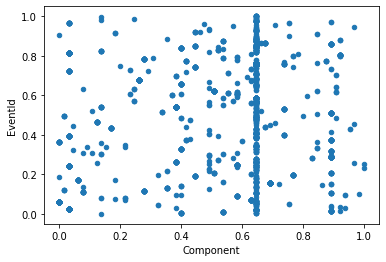

In [ ]:
df.plot.scatter('Component', 'EventId')

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
from numpy import percentile

In [ ]:
from joblib import dump, load

In [ ]:
def cblof_train(tempdf):
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  clf = CBLOF(contamination=0.05,check_estimator=False, random_state=0)
  clf.fit(X)
  dump(clf, 'cblf.joblib')


In [ ]:
def hbos_train(tempdf):
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  clf =HBOS(contamination=0.05)
  clf.fit(X)
  dump(clf, 'hbos.joblib')

In [ ]:
def if_train(tempdf):
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  clf =IForest(contamination=0.05,random_state=0)
  clf.fit(X)
  dump(clf, 'if.joblib')

In [ ]:
def knn_train(tempdf):
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  clf =KNN(contamination=0.05)
  clf.fit(X)
  dump(clf, 'knn.joblib')

In [ ]:
def average_knn_train(tempdf):
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  clf =KNN(method='mean',contamination=0.05)
  clf.fit(X)
  dump(clf, 'average_knn.joblib')

In [ ]:
df_d1 = df[  df['Time'] == 1 ]
df_d2 = df[  df['Time'] == 2 ]
df_d3 = df[  df['Time'] == 3 ]
df_d4 = df[  df['Time'] == 4 ]
df_d5 = df[  df['Time'] == 5 ]
df_d6 = df[  df['Time'] == 6 ]
df_d7 = df[  df['Time'] == 7 ]
df_d8 = df[  df['Time'] == 8 ]

In [ ]:
#training
cblof_train(df)
hbos_train(df)
if_train(df)
knn_train(df)
average_knn_train(df)

In [ ]:
def cblof(tempdf):
  global df1
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)

  outliers_fraction = 0.05
  xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  
  obj = load('cblf.joblib')
  y_pred = obj.predict(X)
  scores_pred = obj.decision_function(X) * -1

  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)

  plt.figure(figsize=(8, 8))

  df1 = tempdf
  df1['outlier'] = y_pred.tolist()
  
  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df1['Component'][df1['outlier'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df1['EventId'][df1['outlier'] == 0]).reshape(-1,1)
  
  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = df1['Component'][df1['outlier'] == 1].values.reshape(-1,1)
  outliers_profit = df1['EventId'][df1['outlier'] == 1].values.reshape(-1,1)
  # return df1      
  print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
      
  # Use threshold value to consider a datapoint inlier or outlier
  # threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
  threshold = percentile(scores_pred, 100 * outliers_fraction)
      
  # decision function calculates the raw anomaly score for every point
  Z = obj.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)
  # fill blue map colormap from minimum anomaly score to threshold value
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
      
  # draw red contour line where anomaly score is equal to thresold
  a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
      
  # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
  b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
  
  c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
      
  plt.axis('tight')   
  plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],)
        #  prop=plt.font_manager.FontProperties(size=20),loc='lower right')
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.title('Cluster-based Local Outlier Factor (CBLOF)')
  plt.show();

In [ ]:
def hbos(tempdf):
  global df1
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  outliers_fraction = 0.05
  xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  
  obj = load('hbos.joblib')
  y_pred = obj.predict(X)
  scores_pred = obj.decision_function(X) * -1
  
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  plt.figure(figsize=(8, 8))
  # copy of dataframe
  df1 = tempdf
  df1['outlier'] = y_pred.tolist()
    
  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df1['Component'][df1['outlier'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df1['EventId'][df1['outlier'] == 0]).reshape(-1,1)
    
  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = df1['Component'][df1['outlier'] == 1].values.reshape(-1,1)
  outliers_profit = df1['EventId'][df1['outlier'] == 1].values.reshape(-1,1)
         
  print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
  # threshold value to consider a datapoint inlier or outlier
  threshold = percentile(scores_pred, 100 * outliers_fraction)
        
  # decision function calculates the raw anomaly score for every point
  Z = obj.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)
  # fill blue map colormap from minimum anomaly score to threshold value
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
  # draw red contour line where anomaly score is equal to thresold
  a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
  # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
  b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
  c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
  plt.axis('tight')  
     
  plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],)
          #  prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.title('Histogram-base Outlier Detection (HBOS)')
  plt.show();

In [ ]:
def IF(tempdf):
  global df1
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  outliers_fraction = 0.05
  xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  
  obj = load('if.joblib')
  y_pred = obj.predict(X)
  scores_pred = obj.decision_function(X) * -1
  
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  plt.figure(figsize=(8, 8))
  # copy of dataframe
  df1 = tempdf
  df1['outlier'] = y_pred.tolist()
    
  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df1['Component'][df1['outlier'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df1['EventId'][df1['outlier'] == 0]).reshape(-1,1)
    
  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = df1['Component'][df1['outlier'] == 1].values.reshape(-1,1)
  outliers_profit = df1['EventId'][df1['outlier'] == 1].values.reshape(-1,1)
         
  print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
  # threshold value to consider a datapoint inlier or outlier
  threshold = percentile(scores_pred, 100 * outliers_fraction)
        
  # decision function calculates the raw anomaly score for every point
  Z = obj.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)
  # fill blue map colormap from minimum anomaly score to threshold value
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
  # draw red contour line where anomaly score is equal to thresold
  a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
  # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
  b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
  c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
  plt.axis('tight')  
     
  plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],)
          #  prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.title('Isolation Forest')
  plt.show();

In [ ]:
def knn(tempdf): 
  global df1
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  outliers_fraction = 0.05
  xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  
  obj = load('knn.joblib')
  y_pred = obj.predict(X)
  scores_pred = obj.decision_function(X) * -1
  
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  plt.figure(figsize=(8, 8))
  # copy of dataframe
  df1 = tempdf
  df1['outlier'] = y_pred.tolist()
    
  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df1['Component'][df1['outlier'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df1['EventId'][df1['outlier'] == 0]).reshape(-1,1)
    
  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = df1['Component'][df1['outlier'] == 1].values.reshape(-1,1)
  outliers_profit = df1['EventId'][df1['outlier'] == 1].values.reshape(-1,1)
         
  print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
  # threshold value to consider a datapoint inlier or outlier
  threshold = percentile(scores_pred, 100 * outliers_fraction)
        
  # decision function calculates the raw anomaly score for every point
  Z = obj.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)
  # fill blue map colormap from minimum anomaly score to threshold value
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
  # draw red contour line where anomaly score is equal to thresold
  a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
  # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
  b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
  c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
  plt.axis('tight')  
     
  plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],)
          #  prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.title('K Nearest Neighbors (KNN)')
  plt.show();

In [ ]:
def averageknn(tempdf):
  global df1
  X1 = tempdf['Component'].values.reshape(-1,1)
  X2 = tempdf['EventId'].values.reshape(-1,1)
  X = np.concatenate((X1,X2),axis=1)
  outliers_fraction = 0.05
  xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  
  obj = load('average_knn.joblib')
  y_pred = obj.predict(X)
  scores_pred = obj.decision_function(X) * -1
  
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  plt.figure(figsize=(8, 8))
  # copy of dataframe
  df1 = tempdf
  df1['outlier'] = y_pred.tolist()
    
  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df1['Component'][df1['outlier'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df1['EventId'][df1['outlier'] == 0]).reshape(-1,1)
    
  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = df1['Component'][df1['outlier'] == 1].values.reshape(-1,1)
  outliers_profit = df1['EventId'][df1['outlier'] == 1].values.reshape(-1,1)
         
  print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
  # threshold value to consider a datapoint inlier or outlier
  threshold = percentile(scores_pred, 100 * outliers_fraction)
        
  # decision function calculates the raw anomaly score for every point
  Z = obj.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)
  # fill blue map colormap from minimum anomaly score to threshold value
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
  # draw red contour line where anomaly score is equal to thresold
  a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
  # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
  b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
  c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
  plt.axis('tight')  
     
  plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],)
          #  prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.title('Average KNN')
  plt.show();

In [ ]:
df1 = pd.DataFrame()

In [ ]:
def out_idx(tempdf):
  index = tempdf.index
  condition = tempdf["outlier"] == 1
  outlier_indices = index[condition]
  return outlier_indices

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS: 19 INLIERS: 197


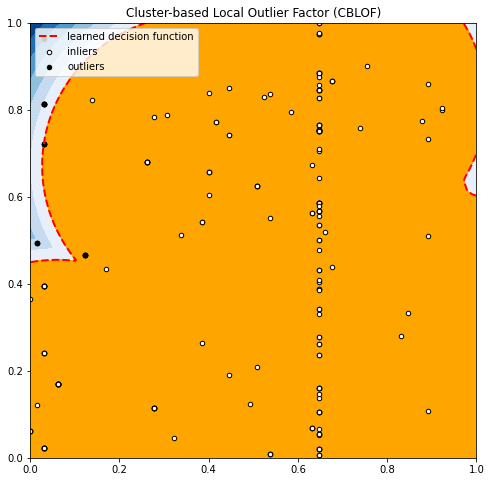

In [ ]:
cblof(df_d1)

In [ ]:
df1

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList,outlier
0,1,Jul,1,09:00:55,calvisitor-10-105-160-95,0.646154,IOThunderboltSwitch<0>(0x0)::listenerCallback ...,0.751634,IOThunderboltSwitch<<*>>(0x0)::listenerCallbac...,"['<0>', '11', '0']",0
1,2,Jul,1,09:01:05,calvisitor-10-105-160-95,0.261538,Thermal pressure state: 1 Memory pressure stat...,0.679739,Thermal pressure state: <*> Memory pressure st...,"['1', '0']",0
2,3,Jul,1,09:01:06,calvisitor-10-105-160-95,0.400000,FA||Url||taskID[2019352994] dealloc,0.839869,FA||Url||taskID[<*>] dealloc,['2019352994'],0
3,4,Jul,1,09:02:26,calvisitor-10-105-160-95,0.646154,ARPT: 620701.011328: AirPort_Brcm43xx::syncPow...,0.584967,ARPT: <*>.<*>: <*> <*>,"['620701.011328', 'AirPort_Brcm43xx::syncPower...",0
4,5,Jul,1,09:02:26,authorMacBook-Pro,0.646154,ARPT: 620702.879952: AirPort_Brcm43xx::platfor...,0.584967,ARPT: <*>.<*>: <*> <*>,"['620702.879952', 'AirPort_Brcm43xx::platformW...",0
...,...,...,...,...,...,...,...,...,...,...,...
211,212,Jul,1,23:32:34,calvisitor-10-105-163-202,0.646154,Previous sleep cause: 5,0.875817,Previous sleep cause: <*>,['5'],0
212,213,Jul,1,23:32:34,calvisitor-10-105-163-202,0.646154,AirPort: Link Up on awdl0,0.885621,AirPort: Link Up on <*>,['awdl0'],0
213,214,Jul,1,23:46:06,calvisitor-10-105-163-202,0.646154,Wake reason: RTC (Alarm),0.065359,Wake reason: <*> <*>,['RTC (Alarm)'],0
214,215,Jul,1,23:46:06,calvisitor-10-105-163-202,0.646154,AppleThunderboltNHIType2::prePCIWake - power u...,0.408497,AppleThunderboltNHIType2::prePCIWake - power u...,['2'],0


In [ ]:
import numpy
colormap = numpy.array(['b','r'])
def get_cats(tempdf):
  categories = numpy.array(list(tempdf.outlier))
  return categories

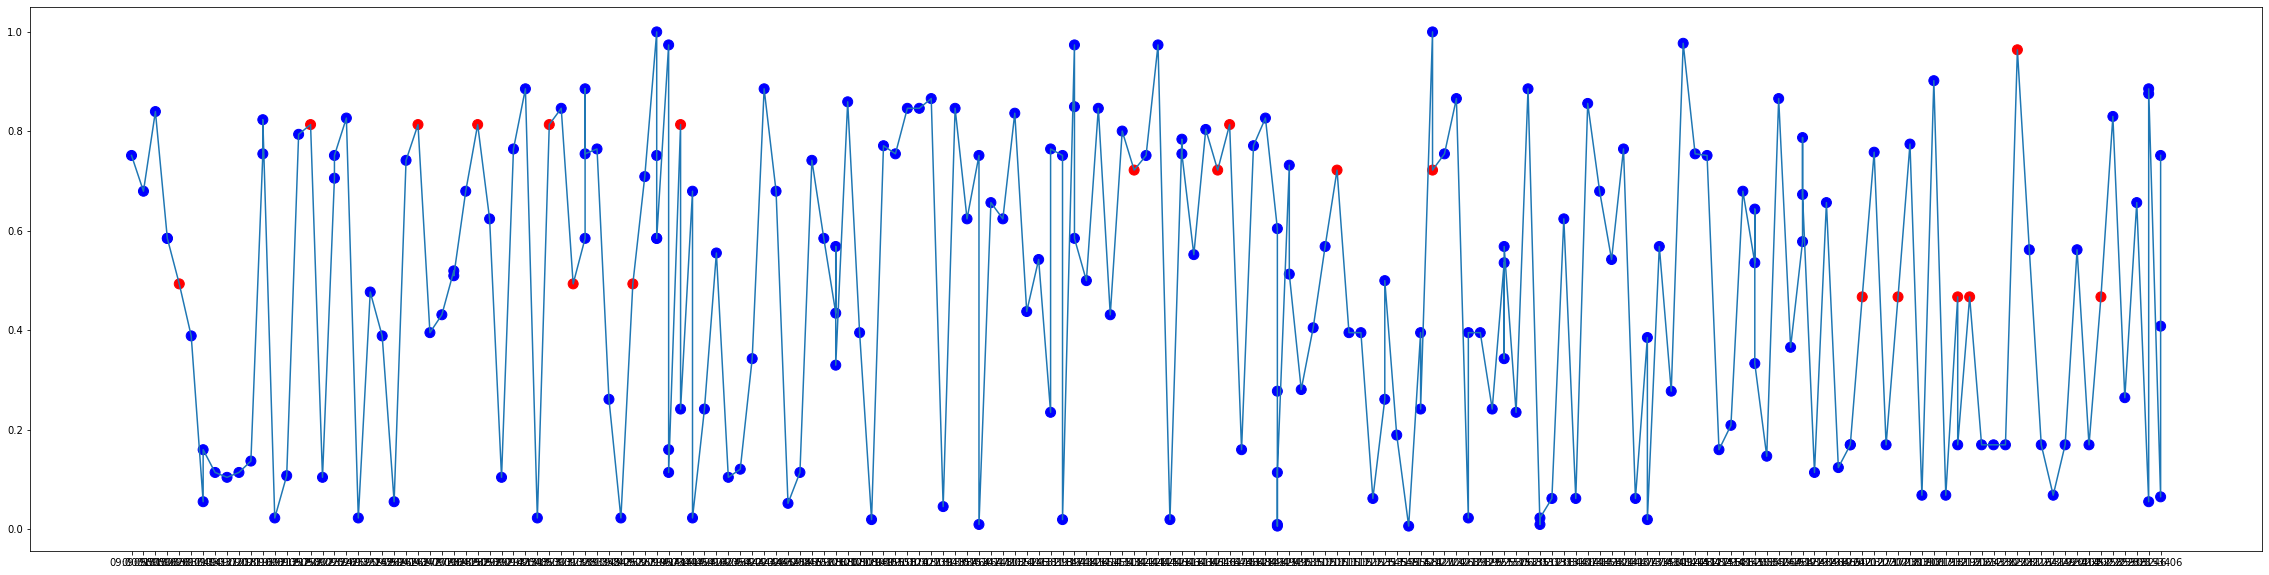

In [ ]:
plt.figure(figsize=(40, 10))
plt.scatter(df1.Pid, df1.EventId, s=100, c=colormap[get_cats(df1)])
plt.plot(df1.Pid,df1.EventId)

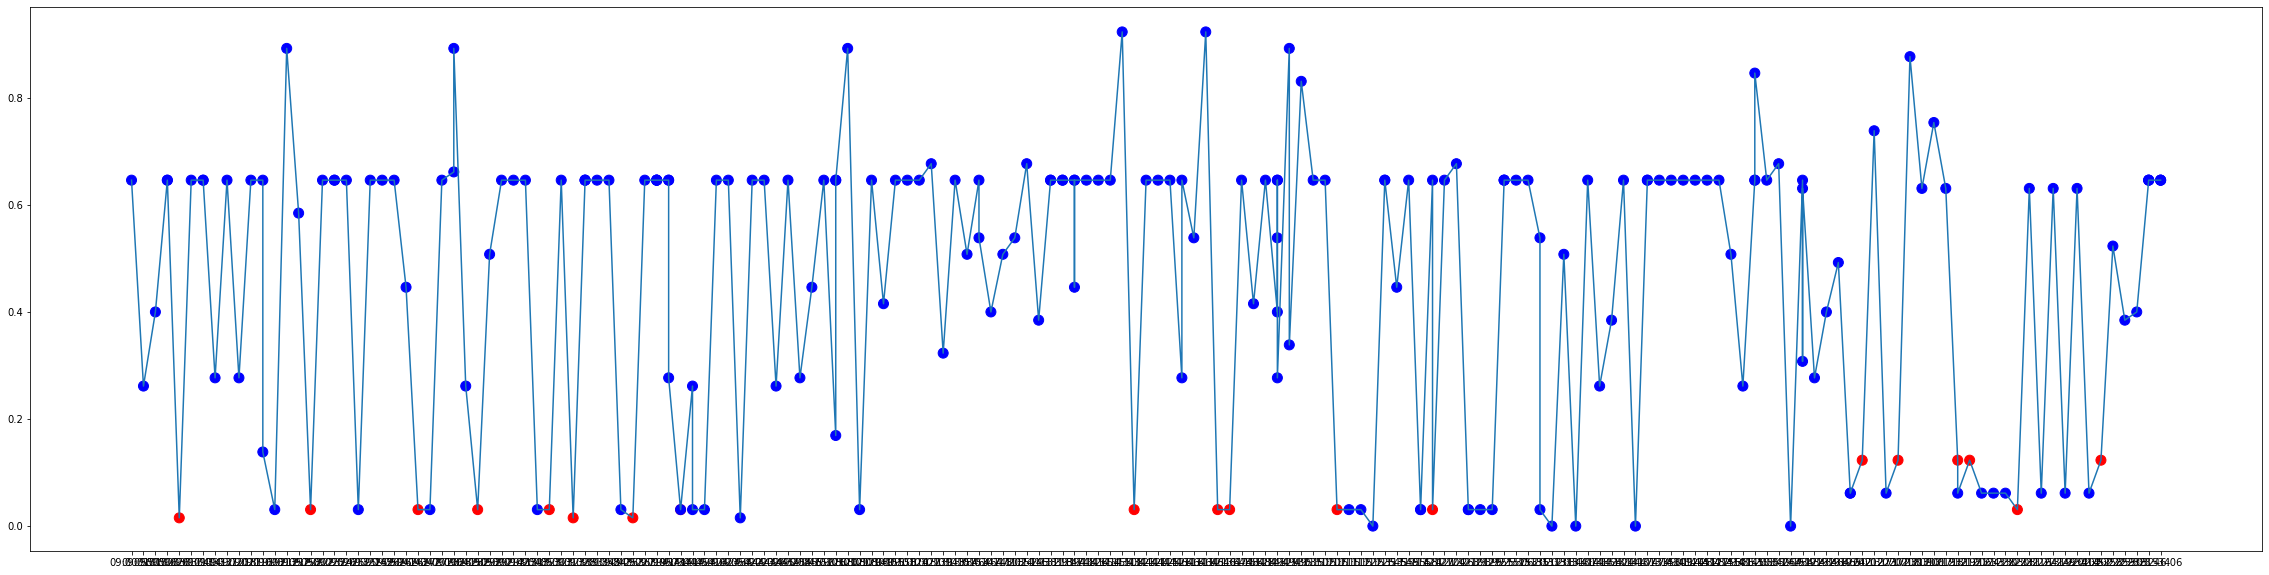

In [ ]:
plt.figure(figsize=(40, 10))
plt.scatter(df1.Pid, df1.Component, s=100, c=colormap[get_cats(df1)])
plt.plot(df1.Pid,df1.Component)

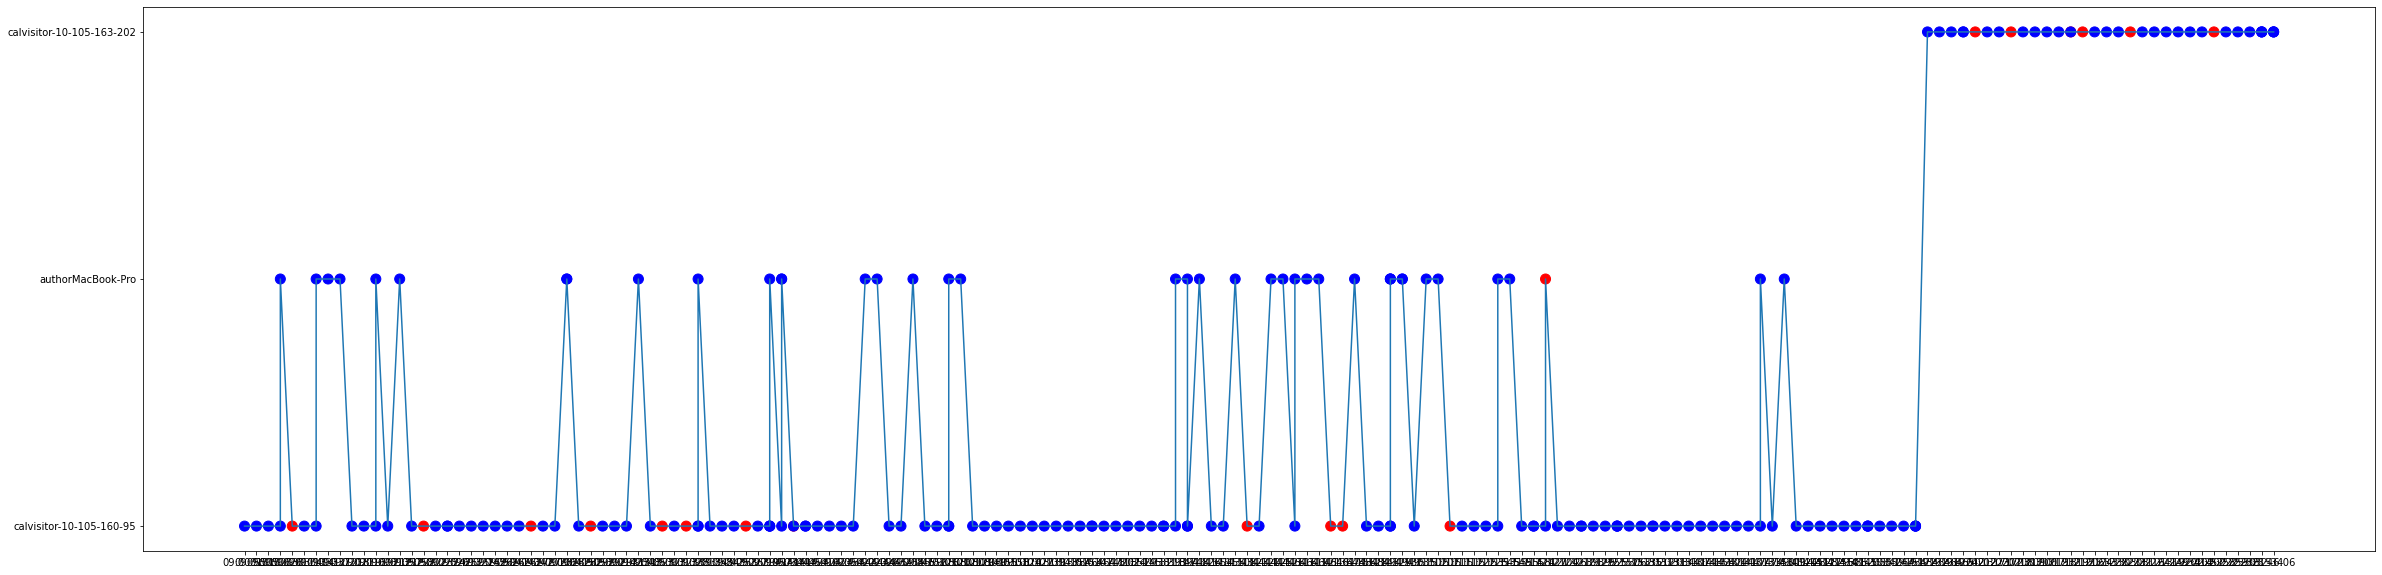

In [ ]:
plt.figure(figsize=(40, 10))
plt.scatter(df1.Pid, df1.Level, s=100, c=colormap[get_cats(df1)])
plt.plot(df1.Pid,df1.Level)

Some tests i have done for modularizing the program